# Drift correction for AeN JC2-2 P11 day 1

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [194]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [195]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename, skiptherows = 18):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=skiptherows)
        
        print(gnsstrack.keys())

        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        
        
        print(thetimes[0:4])
        
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-2], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [196]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [198]:
glon, glat,gtimes = readbasegps("/mnt/documents/JC2-2/P11-16092021/gnss/base3-near/ppp/P11-base3-day1-16092021.pos",
                               skiptherows = 13)

Index(['%  UTC                 ', ' latitude(deg)', 'longitude(deg)',
       ' height(m)', '  Q', ' ns', '  sdn(m)', '  sde(m)', '  sdu(m)',
       ' sdne(m)', ' sdeu(m)', ' sdun(m)', 'age(s)', ' ratio'],
      dtype='object')
['2021/09/16 07:32:05.000' '2021/09/16 07:32:05.500'
 '2021/09/16 07:32:06.000' '2021/09/16 07:32:06.500']


In [199]:
glat[0:5]

array([87.48494511, 87.48494533, 87.48494556, 87.48494607, 87.48494636])

In [200]:
gtimes[-1]

datetime.datetime(2021, 9, 16, 15, 33, 26)

In [201]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
gnssdayseconds = np.array(gnssdayseconds)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to NSIDC north polar stereographic (EPSG 3413)

In [202]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [203]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

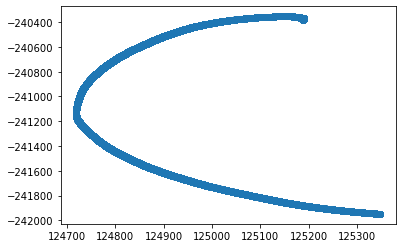

In [204]:
plt.scatter(gnssutm[0], gnssutm[1])

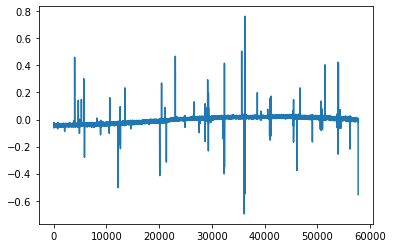

In [205]:
plt.plot(np.diff(gnssutm[0]))

In [206]:
gnssdayseconds[0:5]

array([27125. , 27125.5, 27126. , 27126.5, 27127. ])

## Load  GEM2 data to be drift corrected

In [207]:
gem2inputfile = "/mnt/documents/JC2-2/P11-16092021/gem2/16092021/processed-survey/JC2-2-P11-transect-gem2-531-channel-thickness.csv"

In [208]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [209]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
0     2021-09-16T14:44:40.625000           0         0.0        0.0  0.0  0.0   
1     2021-09-16T14:44:40.734375           1         0.0        0.0  0.0  0.0   
2     2021-09-16T14:44:40.828125           2         0.0        0.0  0.0  0.0   
3     2021-09-16T14:44:40.921875           3         0.0        0.0  0.0  0.0   
4     2021-09-16T14:44:41.031250           4         0.0        0.0  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
6556  2021-09-16T14:52:43.968750        6556         0.0        0.0  0.0  0.0   
6557  2021-09-16T14:52:44.078125        6557         0.0        0.0  0.0  0.0   
6558  2021-09-16T14:52:44.171875        6558         0.0        0.0  0.0  0.0   
6559  2021-09-16T14:52:44.265625        6559         0.0        0.0  0.0  0.0   
6560  2021-09-16T14:52:44.375000        6560         0.0        0.0  0.0  0.0   

      f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0            0.731          0.885           0.881           0.841   
1            0.591          0.865           0.867           0.816   
2            0.904          0.779           0.797           0.796   
3            1.087          0.843           0.778           0.817   
4            1.439          0.856           0.847           0.834   
...            ...            ...             ...             ...   
6556         0.313          0.924           0.935           0.937   
6557         0.356          0.882           1.067           0.913   
6558         0.630          0.956           1.158           0.907   
6559         1.092          0.979           1.056           0.927   
6560         0.637          0.942           0.925           0.936   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0              0.836           0.834            0.837            0.831   
1              0.845           0.835            0.834            0.831   
2              0.848           0.834            0.828            0.829   
3              0.836           0.834            0.830            0.827   
4              0.814           0.831            0.829            0.826   
...              ...             ...              ...              ...   
6556           1.000           0.931            0.965            0.895   
6557           0.998           0.927            0.965            0.886   
6558           1.002           0.921            0.959            0.885   
6559           1.007           0.918            0.957            0.882   
6560           0.977           0.916            0.952            0.879   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               0.835            0.819  
1               0.834            0.821  
2               0.835            0.820  
3               0.838            0.820  
4               0.838            0.822  
...               ...              ...  
6556            0.928            0.824  
6557            0.923            0.816  
6558            0.918            0.807  
6559            0.918            0.805  
6560            0.917            0.797  

[6561 rows x 16 columns]

In [210]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [211]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
8     2021-09-16T14:44:41.421875           8  -17.491677  87.498932  0.0  0.0   
9     2021-09-16T14:44:41.531250           9  -17.491677  87.498932  0.0  0.0   
10    2021-09-16T14:44:41.625000          10  -17.491677  87.498932  0.0  0.0   
11    2021-09-16T14:44:41.734375          11  -17.491677  87.498932  0.0  0.0   
12    2021-09-16T14:44:41.828125          12  -17.491677  87.498932  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
6542  2021-09-16T14:52:42.578125        6542  -17.455367  87.496877  0.0  0.0   
6543  2021-09-16T14:52:42.671875        6543  -17.455365  87.496877  0.0  0.0   
6544  2021-09-16T14:52:42.765625        6544  -17.455364  87.496877  0.0  0.0   
6545  2021-09-16T14:52:42.875000        6545  -17.455363  87.496877  0.0  0.0   
6546  2021-09-16T14:52:42.968750        6546  -17.455362  87.496877  0.0  0.0   

      f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
8            0.726          0.862           0.816           0.840   
9            0.864          0.772           0.802           0.843   
10           0.470          0.806           0.866           0.830   
11           0.856          0.829           0.926           0.824   
12           1.127          0.880           0.986           0.832   
...            ...            ...             ...             ...   
6542         1.383          1.440           1.213           1.242   
6543         1.414          1.176           1.363           1.209   
6544         0.894          1.208           1.309           1.179   
6545         0.534          1.159           1.331           1.146   
6546         0.339          1.130           1.245           1.146   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
8              0.841           0.838            0.840            0.832   
9              0.845           0.830            0.836            0.833   
10             0.846           0.829            0.837            0.833   
11             0.846           0.831            0.836            0.830   
12             0.844           0.835            0.834            0.829   
...              ...             ...              ...              ...   
6542           1.301           1.255            1.255            1.213   
6543           1.257           1.207            1.223            1.177   
6544           1.249           1.179            1.191            1.143   
6545           1.212           1.142            1.156            1.107   
6546           1.170           1.109            1.126            1.077   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
8               0.835            0.819  
9               0.835            0.820  
10              0.836            0.821  
11              0.837            0.820  
12              0.833            0.820  
...               ...              ...  
6542            1.226            1.183  
6543            1.195            1.149  
6544            1.159            1.109  
6545            1.127            1.073  
6546            1.097            1.035  

[6488 rows x 16 columns]

In [212]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [213]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [214]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

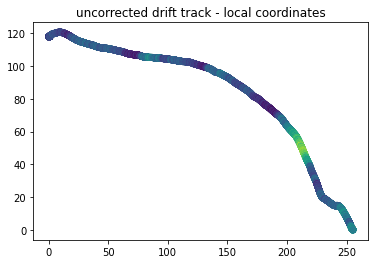

In [215]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [216]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))
gem2dayseconds = np.array(gem2dayseconds)

In [217]:
gem2dayseconds = np.round(gem2dayseconds, 4)

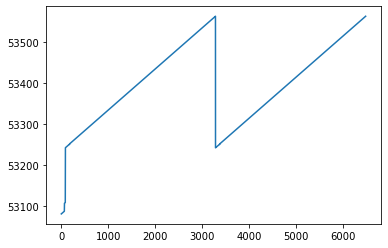

In [218]:
plt.plot(gem2dayseconds)

In [219]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

53081.4219
51912
52876


In [220]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [221]:
start

53081.4219

In [222]:
end

53562.9688

In [223]:
gnssdayseconds = np.array(gnssdayseconds)

In [224]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [225]:
trimmedtime[0]

53081.0

In [226]:
trimmedtime[-1]

53563.0

In [227]:
gem2dayseconds[0]

53081.4219

In [228]:
gem2dayseconds[-1]

53562.9688

In [229]:
gnssdayseconds[0]

27125.0

In [230]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [231]:
timesteps = np.round(timesteps, 4)

In [232]:
np.where(timesteps == gem2dayseconds[10001])

IndexError: index 10001 is out of bounds for axis 0 with size 6488

In [233]:
timesteps[9219]

53081.4219

In [234]:
gem2dayseconds[-1]

53562.9688

In [235]:
gnssdayseconds[-1]

56006.0

In [236]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        pass
        #print(thistimeindex[0])
        #print(thistime)

CPU times: user 15.4 s, sys: 0 ns, total: 15.4 s
Wall time: 15.4 s


In [237]:
len(timeindexes)

6488

In [238]:
len(gem2dayseconds)

6488

In [239]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [240]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [241]:
gnss_gem2_match_eastings[0]

array([125158.43181286])

In [242]:
gnss_gem2_match_northings[0]

array([-240352.37896344])

In [243]:
len(gnss_gem2_match_eastings)

6488

In [244]:
len(gem2easting)

6488

In [245]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [246]:
gnss_gem2_match_eastings[0]

125158.43181286301

In [247]:
gem2easting[0]

125157.39283154595

In [248]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [249]:
local_gem2_east[0]

-1.0389813170622801

In [250]:
local_gem2_north[0]

12.514798378426349

In [251]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [252]:
world_gem2_east.size

6488

In [253]:
gnss_gem2_match_eastings[0]

125158.43181286301

In [254]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [255]:
gem2_header = """AeN JC2-2 2021 P11 GEM2 measurements
GEM2-531 electromagnetic induction sounder
16 September 2021
Adam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [256]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [257]:
gem2out = gem2data.copy()

In [258]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [259]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [260]:
gem2out.insert(2, "easting", world_gem2_east)

In [261]:
gem2out.insert(3, "northing", world_gem2_north)

In [262]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [263]:
gem2_output = "/mnt/documents/JC2-2/P11-16092021/GEM2data-driftcorrected-16092021.csv"

In [264]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [265]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the NPI 1 magnaprobe, add 1024 weeks to observations

In [162]:
magnaprobeinputfile = "/mnt/documents/JC2-2/P11-16092021/magnaprobe/17092021/NPI7.dat"


In [163]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [164]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [165]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [166]:
weekdelta = timedelta(weeks=1024)

In [167]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [168]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [169]:
mp_dayseconds = np.round(mp_dayseconds, 2)

In [170]:
gnssdayseconds

array([27125. , 27125.5, 27126. , ..., 56005. , 56005.5, 56006. ])

In [171]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

41733.35
29216
53357


In [172]:
gnssdayseconds = np.array(gnssdayseconds)

In [173]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [174]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [175]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 2.26 s, sys: 0 ns, total: 2.26 s
Wall time: 2.26 s


In [176]:
len(timeindexes)

3545

In [177]:
len(mp_dayseconds)

3545

In [178]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [179]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [180]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [181]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

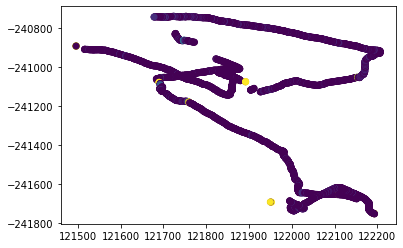

In [182]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [183]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [184]:
len(mpeasting)

3545

In [185]:
len(gnss_mp_match_eastings)

3545

Convert back to world coordinates

In [188]:
world_mp_east = local_mp_east + gnss_mp_match_eastings[0]
world_mp_north = local_mp_north + gnss_mp_match_northings[0]

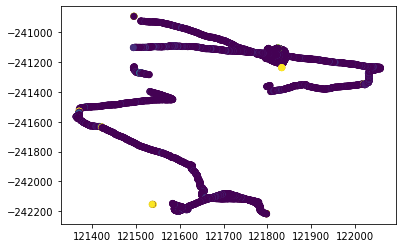

In [189]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [360]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [361]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [364]:
mp_output = "/mnt/documents/JC2-2/P11-16092021/magnaprobe/16092021/MPdata-driftcorrected-datefixed.csv"

In [365]:
mp_header = """AeN JC2-2 P11 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
16 September 2021
Adam Steer / Anca Cristea
Time corrected: adding 1024 weeks to timestamps accounting for the 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [366]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [367]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

In [145]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

This is tricky - drone flights occurred the day before the ice station started. So we use a different GPS station to get local coordinates.

In [266]:
cameracentrefile = "/mnt/documents/ANAFI-USA/jc2-2/15092021-p11-prestation/cameracentres.csv"

In [267]:
cameradata = pd.read_csv(cameracentrefile)

In [268]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [269]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [270]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

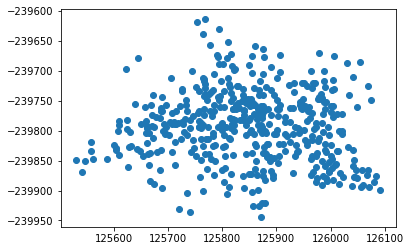

In [271]:
plt.scatter(cameraeasting, cameranorthing)

In [272]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P1364152.JPG  2021:09:15 14:09:30                 812    87.501256   
1    ./jpg/P1364153.JPG  2021:09:15 14:09:38                 193    87.501248   
2    ./jpg/P1364154.JPG  2021:09:15 14:09:45                 321    87.501232   
3    ./jpg/P1364155.JPG  2021:09:15 14:09:56                 175    87.501196   
4    ./jpg/P1364156.JPG  2021:09:15 14:09:59                 557    87.501124   
..                  ...                  ...                 ...          ...   
463  ./jpg/P1444621.JPG  2021:09:15 15:11:58                 853    87.499817   
464  ./jpg/P1444622.JPG  2021:09:15 15:12:01                 717    87.499823   
465  ./jpg/P1444623.JPG  2021:09:15 15:12:04                 747    87.499825   
466  ./jpg/P1444624.JPG  2021:09:15 15:12:07                 995    87.499824   
467  ./jpg/P1444625.JPG  2021:09:15 15:12:11                 679    87.499968   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0      -17.343697    20.341520            13.019663       0.573847   
1      -17.343673    26.911497            16.850540       0.637024   
2      -17.343996    46.217884            37.871693       0.672086   
3      -17.341307    62.492874            60.847595       0.721803   
4      -17.334934    62.613407            60.900375       0.842199   
..            ...          ...                  ...            ...   
463    -17.304737    58.296875            47.364784       0.891403   
464    -17.300056    58.242653            47.398396       0.891403   
465    -17.295240    58.179031            47.363541       0.926553   
466    -17.291356    58.011227            47.401520       0.969381   
467    -17.290118    57.248039            47.332199       1.004988   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             1.2           1.448721          0.004151      -172.368515  
1             1.3         -87.486504          1.028933      -160.865768  
2             1.3         -87.456161          0.078770       -64.430367  
3             1.4         -87.462402         -0.613589       -97.999168  
4             1.6         -87.454552          0.022090       -98.749359  
..            ...                ...               ...              ...  
463           1.5         -68.917534          0.019523      -143.458160  
464           1.6         -68.911331          0.029285      -143.541748  
465           1.7         -68.910522         -0.009031      -143.376846  
466           1.8         -68.912621          0.011895      -143.525253  
467           1.9         -68.907089          0.001418      -143.545090  

[468 rows x 12 columns]

In [273]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [274]:
cam_utm[0][0]

125660.78472506133

In [275]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [276]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.812, 0.193, 0.321, 0.175, 0.557]

In [277]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [278]:
cam_dayseconds[0]

43740.812

In [279]:
## read the relevant GPS file

clons, clats, ctimes = readbasegps("/mnt/documents/JC2-2/P11-16092021/garmin/station-fixed/Current.gpx")

/mnt/documents/JC2-2/P11-16092021/garmin/station-fixed/Current.gpx


In [299]:
clats = np.array(clats)
clons = np.array(clons)
ctimes = np.array(ctimes)

In [300]:
themonths = [thetime.month for thetime in ctimes]
thedays = [thetime.day for thetime in ctimes]

In [301]:
themonths = np.array(themonths)
thedays = np.array(thedays)

In [302]:
thisday = np.where((themonths[:] == 9) & (thedays == 15))

In [303]:
thisday

(array([3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904,
        3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915,
        3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926,
        3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937,
        3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948,
        3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959,
        3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970,
        3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981,
        3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992,
        3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003,
        4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014,
        4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025,
        4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036,
        4037, 4038, 4039]),)

In [304]:

clats[thisday]
ctimes[thisday]

array([datetime.datetime(2021, 9, 15, 12, 5, 24),
       datetime.datetime(2021, 9, 15, 12, 5, 42),
       datetime.datetime(2021, 9, 15, 12, 5, 44),
       datetime.datetime(2021, 9, 15, 12, 6, 21),
       datetime.datetime(2021, 9, 15, 12, 6, 54),
       datetime.datetime(2021, 9, 15, 12, 7, 15),
       datetime.datetime(2021, 9, 15, 12, 7, 48),
       datetime.datetime(2021, 9, 15, 12, 8, 28),
       datetime.datetime(2021, 9, 15, 12, 9, 10),
       datetime.datetime(2021, 9, 15, 12, 9, 59),
       datetime.datetime(2021, 9, 15, 12, 10, 46),
       datetime.datetime(2021, 9, 15, 12, 11, 6),
       datetime.datetime(2021, 9, 15, 12, 11, 26),
       datetime.datetime(2021, 9, 15, 12, 12, 3),
       datetime.datetime(2021, 9, 15, 12, 12, 24),
       datetime.datetime(2021, 9, 15, 12, 13, 13),
       datetime.datetime(2021, 9, 15, 12, 13, 53),
       datetime.datetime(2021, 9, 15, 12, 14, 19),
       datetime.datetime(2021, 9, 15, 12, 15, 9),
       datetime.datetime(2021, 9, 15, 12, 15

In [305]:
the_clats = clats[thisday]
the_clons = clons[thisday]
the_ctimes = ctimes[thisday]


In [306]:
len(the_ctimes)

146

In [307]:
the_ctimes[0]

datetime.datetime(2021, 9, 15, 12, 5, 24)

In [308]:
the_ctimes[-1]

datetime.datetime(2021, 9, 15, 13, 19, 1)

In [310]:
gnssdayseconds=[]
for thetime in the_ctimes:
    hour = thetime.hour
    minute = thetime.minute
    second = thetime.second
    millisecond = float(thetime.microsecond) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
gnssdayseconds = np.array(gnssdayseconds)

In [311]:
the_clats

array([87.50118175, 87.50114948, 87.50114822, 87.50113238, 87.50112969,
       87.50111938, 87.50110882, 87.50110178, 87.50105501, 87.50107161,
       87.50107882, 87.50106725, 87.50106088, 87.5010561 , 87.50105241,
       87.50103657, 87.50103313, 87.50103439, 87.50103422, 87.50103942,
       87.50100363, 87.5010033 , 87.50099114, 87.50097798, 87.5009639 ,
       87.50096826, 87.50095627, 87.50095644, 87.50096248, 87.50096474,
       87.50094596, 87.50093515, 87.50092803, 87.50091772, 87.50092291,
       87.50090523, 87.50089735, 87.50090171, 87.50087849, 87.50084873,
       87.50084873, 87.50085292, 87.50084412, 87.50083666, 87.50083733,
       87.50084035, 87.50083423, 87.50081914, 87.50082208, 87.5008235 ,
       87.5008106 , 87.50079517, 87.50079232, 87.50078696, 87.50076936,
       87.50074958, 87.50073382, 87.50072644, 87.50072426, 87.50072736,
       87.5007049 , 87.50068487, 87.50066785, 87.50066257, 87.50066668,
       87.50065771, 87.50063382, 87.50063583, 87.50061639, 87.50

In [312]:
gnssutm = thetransform.transform(the_clats, the_clons)
gnssutm = np.array(gnssutm)

In [313]:
gnssutm[0]

array([125646.03039184, 125649.06066818, 125649.08040583, 125651.50400138,
       125654.17783847, 125655.75696446, 125657.79744884, 125658.88799061,
       125662.56255517, 125666.48320787, 125669.85511413, 125671.57856941,
       125672.5778677 , 125675.05505931, 125677.07013007, 125679.42789839,
       125682.08565086, 125683.92840604, 125687.4120378 , 125690.3935096 ,
       125697.06601062, 125699.36422157, 125700.4735483 , 125701.16830535,
       125704.35078814, 125707.89360714, 125712.52335027, 125715.94232742,
       125719.39366914, 125720.96118652, 125722.61605352, 125723.69516503,
       125727.3074263 , 125730.38187696, 125732.19499572, 125733.93120423,
       125734.89989369, 125735.98798125, 125740.56701222, 125744.68932865,
       125747.40560872, 125749.25563772, 125750.61771291, 125751.0847484 ,
       125751.79995857, 125753.64939903, 125755.01083553, 125756.86930895,
       125757.57970615, 125759.82079964, 125762.38485814, 125764.64156216,
       125765.06951187, 1

In [288]:
gnssutm[0]

array([125646.03039184, 125649.06066818, 125649.08040583, 125651.50400138,
       125654.17783847, 125655.75696446, 125657.79744884, 125658.88799061,
       125662.56255517, 125666.48320787, 125669.85511413, 125671.57856941,
       125672.5778677 , 125675.05505931, 125677.07013007, 125679.42789839,
       125682.08565086, 125683.92840604, 125687.4120378 , 125690.3935096 ,
       125697.06601062, 125699.36422157, 125700.4735483 , 125701.16830535,
       125704.35078814, 125707.89360714, 125712.52335027, 125715.94232742,
       125719.39366914, 125720.96118652, 125722.61605352, 125723.69516503,
       125727.3074263 , 125730.38187696, 125732.19499572, 125733.93120423,
       125734.89989369, 125735.98798125, 125740.56701222, 125744.68932865,
       125747.40560872, 125749.25563772, 125750.61771291, 125751.0847484 ,
       125751.79995857, 125753.64939903, 125755.01083553, 125756.86930895,
       125757.57970615, 125759.82079964, 125762.38485814, 125764.64156216,
       125765.06951187, 1

In [314]:
cam_utm[0]

array([125660.78472506, 125661.28760831, 125660.71620747, 125673.81339786,
       125704.07703292, 125731.22701312, 125757.80825997, 125740.68691086,
       125728.06039143, 125711.15163847, 125624.29139535, 125688.20002096,
       125714.36537935, 125757.76827624, 125799.91357451, 125741.26178919,
       125726.45870908, 125697.17397089, 125604.55280504, 125630.11295928,
       125650.89246126, 125670.48146915, 125734.22572408, 125757.82453726,
       125780.83488964, 125813.91741902, 125825.00083115, 125766.85644204,
       125712.21065815, 125664.62408616, 125562.11585456, 125587.46660602,
       125610.62420044, 125694.81901642, 125715.8070305 , 125755.91255245,
       125824.96848501, 125820.19855209, 125782.51843276, 125660.6623405 ,
       125632.64276171, 125604.00105399, 125541.88902874, 125713.45343897,
       125735.44236727, 125760.52658845, 125816.36924508, 125801.52366832,
       125708.31164926, 125680.42196397, 125628.06529476, 125600.87076499,
       125558.86322016, 1

In [315]:
gnssdayseconds[0]

43524.0

In [316]:
gnssdayseconds[-1]

47941.0

In [317]:
len(gnssdayseconds)

146

In [318]:
len(cam_dayseconds)

468

In [319]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

43740.812
7
130


In [320]:
len(gnss_trimmedtime)

124

In [321]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [322]:
trimmedeast[0]

125658.88799060517

In [323]:
gnssutm[0][0:5]

array([125646.03039184, 125649.06066818, 125649.08040583, 125651.50400138,
       125654.17783847])

In [324]:
cameraeasting[0]

125660.78472506133

In [325]:
min(cam_dayseconds)

43740.175

In [326]:
max(cam_dayseconds)

47520.995

In [327]:
min(gnssdayseconds)

43524.0

In [328]:
max(gnssdayseconds)

47941.0

In [329]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [330]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 851 ms, sys: 5.72 ms, total: 856 ms
Wall time: 869 ms


In [331]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [332]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [333]:
local_cam_east[0]

-0.9739753680623835

In [334]:
local_cam_north[0]

22.829677086236188

In [335]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

-9.145489400834776

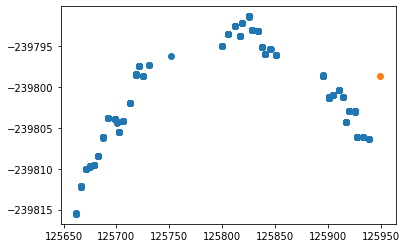

In [336]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [337]:
cameraeasting[0]

125660.78472506133

In [338]:
gem2easting[0]

125157.39283154595

In [339]:
cameranorthing[0]

-239792.69472229626

In [340]:
gem2northing[0]

-240339.8641650642

In [341]:
local_gem2_east[0]

-1.0389813170622801

In [342]:
local_mp_east[0]

-3264.2990476039704

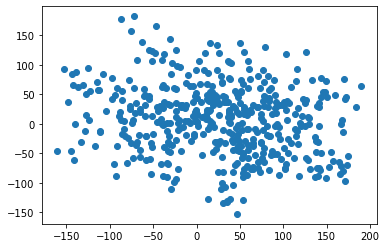

In [343]:
plt.scatter(local_cam_east, local_cam_north)

In [344]:
gnss_gem2_match_eastings[0]

125158.43181286301

In [345]:
local_gem2_east[0]

-1.0389813170622801

In [347]:
world_cam_east = local_cam_east + gnss_gem2_match_eastings[0]
world_cam_north = local_cam_north + gnss_gem2_match_northings[0]

In [348]:
world_cam_east[0]

125157.45783749495

In [349]:
world_gem2_east[0]

125157.39283154595

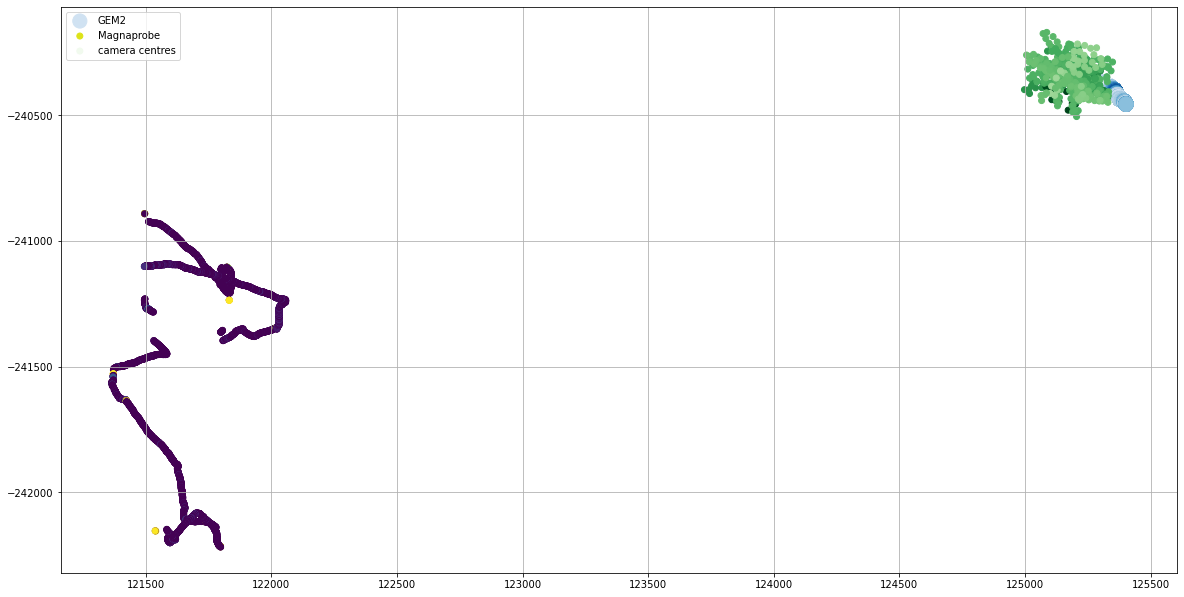

In [350]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [351]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [352]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [353]:
cam_out = cameradata.copy()

In [354]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [355]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [356]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/jc2-2/15092021-p11-prestation/driftcorrected-for-exiftool.csv"

In [357]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [358]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

-0.002240161623248582

In [359]:
cam_out['GPSLatitude'][0]

87.49901583834895